## import libraries 

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

In [2]:
# read shape file
eu_shape_file = "../input_data/EuropeBoundary.shp"
gdf = gpd.read_file(eu_shape_file)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [3]:
# setup dask cluster
cluster = LocalCluster(n_workers=5, threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 5,Total memory: 15.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34535,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 5
Started: Just now,Total memory: 15.29 GiB
Comm: tcp://127.0.0.1:34565,Total threads: 1
Dashboard: http://127.0.0.1:42275/status,Memory: 3.06 GiB
Nanny: tcp://127.0.0.1:40273,


In [4]:
def preprocess(ds):
    # Convert the longitude coordinates from [0, 360] to [-180, 180]
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    return ds

In [ ]:
# open era5_land (two years, each year one file)
data_name = "../data/era5-land_total_precipitation_2018-*.nc"
era5_land_data = xr.open_mfdataset(data_name, preprocess=preprocess, chunks={'longitude': 250, 'latitude': 250, 'time': 750})

In [6]:
# Sort the Dataset 
ds = era5_land_data.sortby(['longitude', 'latitude'])

# Cut the dataset
masked_ds = ds.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))

# Rechunking needed after sel
masked_ds = masked_ds.chunk(chunks={'longitude': 250, 'latitude': 250, 'time': 750})

# check coords values
masked_ds

<xarray.Dataset>
Dimensions:    (longitude: 1002, latitude: 469, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -31.2 -31.1 -31.0 -30.9 ... 68.7 68.8 68.9
  * latitude   (latitude) float32 35.0 35.1 35.2 35.3 ... 81.5 81.6 81.7 81.8
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-02-28T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(750, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-27 10:42:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
%%time
zarr_path = f'../data/era5land.zarr'
masked_ds.to_zarr(zarr_path, mode='w')

/home/sarah/miniconda3/envs/emulator/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/sarah/miniconda3/envs/emulator/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/sarah/miniconda3/envs/emulator/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/home/sarah/miniconda3/envs/emulator/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib`

CPU times: user 5.88 s, sys: 1.36 s, total: 7.24 s
Wall time: 38.1 s


In [8]:
client.shutdown()

In [9]:
!du -h $zarr_path

16K	../data/era5land.zarr/latitude
235M	../data/era5land.zarr/tp
16K	../data/era5land.zarr/longitude
16K	../data/era5land.zarr/time
235M	../data/era5land.zarr


In [10]:
era5_land_data = xr.open_zarr(zarr_path)
era5_land_data 

<xarray.Dataset>
Dimensions:    (latitude: 469, longitude: 1002, time: 1416)
Coordinates:
  * latitude   (latitude) float32 35.0 35.1 35.2 35.3 ... 81.5 81.6 81.7 81.8
  * longitude  (longitude) float32 -31.2 -31.1 -31.0 -30.9 ... 68.7 68.8 68.9
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-02-28T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(750, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-27 10:42:44 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

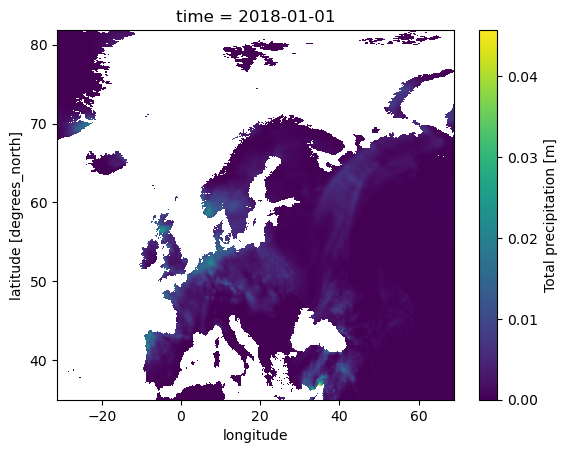

In [11]:
era5_land_data.tp.isel(time=0).plot()